# jobflow

https://github.com/BAMresearch/NFDI4IngScientificWorkflowRequirements

## Define workflow with jobflow

In [1]:
from jobflow import job, Flow

from python_workflow_definition.jobflow import write_workflow_json

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
from nfdi_ing_workflow import (
    generate_mesh as _generate_mesh, 
    convert_to_xdmf as _convert_to_xdmf,
    poisson as _poisson,
    plot_over_line as _plot_over_line,
    substitute_macros as _substitute_macros,
    compile_paper as _compile_paper,
)

In [3]:
generate_mesh = job(_generate_mesh)
convert_to_xdmf = job(_convert_to_xdmf, data=["xdmf_file", "h5_file"])
poisson = job(_poisson, data=["numdofs", "pvd_file", "vtu_file"])
plot_over_line = job(_plot_over_line)
substitute_macros = job(_substitute_macros)
compile_paper = job(_compile_paper)

In [4]:
domain_size = 2.0

In [5]:
gmsh_output_file = generate_mesh(
    domain_size=domain_size,
)

In [6]:
meshio_output_dict = convert_to_xdmf(
    gmsh_output_file=gmsh_output_file.output,
)

In [7]:
poisson_dict = poisson(
    meshio_output_xdmf=meshio_output_dict.output.xdmf_file, 
    meshio_output_h5=meshio_output_dict.output.h5_file,
)

In [8]:
pvbatch_output_file = plot_over_line(
    poisson_output_pvd_file=poisson_dict.output.pvd_file, 
    poisson_output_vtu_file=poisson_dict.output.vtu_file,
)

In [9]:
macros_tex_file = substitute_macros( 
    pvbatch_output_file=pvbatch_output_file.output, 
    ndofs=poisson_dict.output.numdofs, 
    domain_size=domain_size,
)

In [10]:
paper_output = compile_paper(
    macros_tex=macros_tex_file.output, 
    plot_file=pvbatch_output_file.output,
)

In [11]:
flow = Flow([gmsh_output_file, meshio_output_dict, poisson_dict, pvbatch_output_file, macros_tex_file, paper_output])

In [12]:
workflow_json_filename = "jobflow_nfdi.json"

In [13]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

## Load Workflow with aiida

In [14]:
from aiida import load_profile

load_profile()

Profile<uuid='3b96612f59bb474b9a4c16a7676ab9bc' name='pwd'>

In [15]:
from python_workflow_definition.aiida import load_workflow_json

In [16]:
wg = load_workflow_json(file_name=workflow_json_filename)
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

In [17]:
wg.run()

04/04/2025 02:47:35 PM <1667> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_mesh1
04/04/2025 02:47:38 PM <1667> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2|WorkGraphEngine|update_task_state]: Task: generate_mesh1, type: PyFunction, finished.
04/04/2025 02:47:38 PM <1667> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2|WorkGraphEngine|continue_workgraph]: tasks ready to run: convert_to_xdmf2
04/04/2025 02:47:41 PM <1667> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2|WorkGraphEngine|update_task_state]: Task: convert_to_xdmf2, type: PyFunction, finished.
04/04/2025 02:47:41 PM <1667> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2|WorkGraphEngine|continue_workgraph]: tasks ready to run: poisson3
04/04/2025 02:47:46 PM <1667> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2|WorkGraphEngin

## Load Workflow with pyiron_base

In [18]:
from pyiron_base import Project

In [19]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [20]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

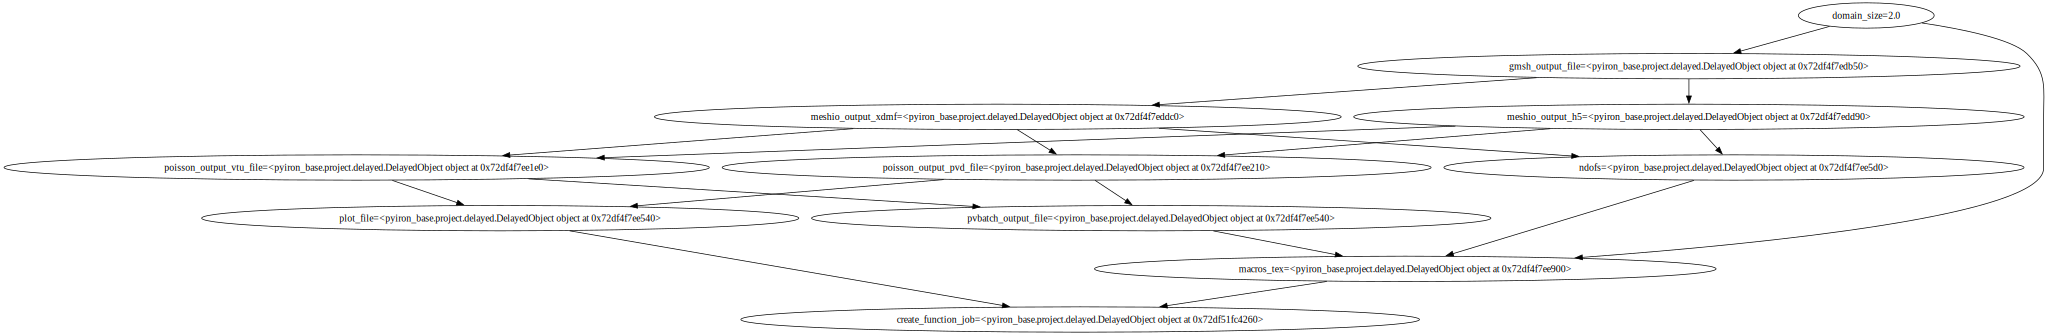

In [21]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

In [22]:
delayed_object.pull()

The job generate_mesh_0b48cf5155cd6802c17d20bb58104132 was saved and received the ID: 1
The job convert_to_xdmf_29ad6ec6927268429dc9aef8166fde43 was saved and received the ID: 2
The job poisson_a0224b23ceb2119d105a5d98ef37f93e was saved and received the ID: 3
The job plot_over_line_82b37a42e0747f11d9a7f6318f63ac6b was saved and received the ID: 4
The job substitute_macros_874fc185ecec04b4cb9537c58b7efb7b was saved and received the ID: 5
The job compile_paper_3cee534ffe692833d37faf1fd2170cb6 was saved and received the ID: 6


'/home/jovyan/postprocessing/paper.pdf'

In [23]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,None,generate_mesh_0b48cf5155cd6802c17d20bb58104132,/generate_mesh_0b48cf5155cd6802c17d20bb58104132,None,/home/jovyan/test/,2025-04-04 14:47:55.342358,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
1,2,finished,None,convert_to_xdmf_29ad6ec6927268429dc9aef8166fde43,/convert_to_xdmf_29ad6ec6927268429dc9aef8166fde43,None,/home/jovyan/test/,2025-04-04 14:47:56.888684,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
2,3,finished,None,poisson_a0224b23ceb2119d105a5d98ef37f93e,/poisson_a0224b23ceb2119d105a5d98ef37f93e,None,/home/jovyan/test/,2025-04-04 14:47:58.709291,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
3,4,finished,None,plot_over_line_82b37a42e0747f11d9a7f6318f63ac6b,/plot_over_line_82b37a42e0747f11d9a7f6318f63ac6b,None,/home/jovyan/test/,2025-04-04 14:48:01.939684,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
4,5,finished,None,substitute_macros_874fc185ecec04b4cb9537c58b7efb7b,/substitute_macros_874fc185ecec04b4cb9537c58b7efb7b,None,/home/jovyan/test/,2025-04-04 14:48:03.947338,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
5,6,finished,None,compile_paper_3cee534ffe692833d37faf1fd2170cb6,/compile_paper_3cee534ffe692833d37faf1fd2170cb6,None,/home/jovyan/test/,2025-04-04 14:48:05.245018,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
